In [2]:
import pandas as pd
import tensorflow_hub as hub
import openai 
import numpy as np
import altair as alt
from openai import OpenAI
from sql_metadata import Parser
import os
from IPython.display import display, Markdown
import ast
import cx_Oracle
import re

from pathlib import Path
import json
import requests
import datetime
import matplotlib.pyplot as plt

2024-06-13 08:24:48.709566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 08:24:48.709637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 08:24:48.731748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 08:24:48.776335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 08:24:49.639781: W tensorflow/compiler/tf2

In [3]:
prefix = Path.cwd().parent.parent
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
prefix = str(prefix)

# Analysis of 50 handcrafted queries on MIT DataWarehouse
These examples will all be run in GPT3.5-turbo.
This first approach shows the exact comparison in accuracy and the metrics for table-retrieval on only sql-logs. Recall and F1-Score are on the same level.

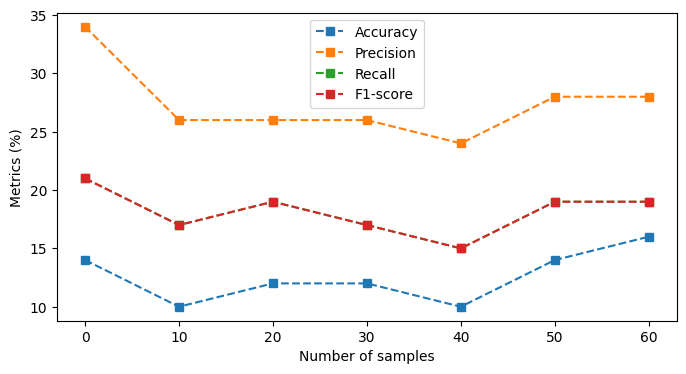

In [10]:

example_size  =[0, 10, 20, 30, 40,50, 60]
accuracy_only_sql = [14, 10, 12, 12, 10, 14, 16]
precision_only_sql = [34, 26, 26, 26, 24, 28, 28]
recall_only_sql = [21, 17, 19, 17, 15, 19, 19]
f1_only_sql = [21, 17, 19, 17, 15, 19, 19]
fig, ax = plt.subplots(
    figsize=(8, 4)
)  # This sets the figure size to 6 inches wide by 5 inches high
# Plot the baseline

x= example_size
y=[accuracy_only_sql, precision_only_sql, recall_only_sql, f1_only_sql]
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
# Plot the three model lines
for i, label in enumerate(labels):
    ax.plot(x, y[i], linestyle='--', marker='s', label=label)

ax.set_xlabel("Number of samples")
ax.set_ylabel("Metrics (%)")
ax.legend()
plt.show()

### Comparison of q/a-pairs with simple sql-logs

Now we compare exact accuracies in the output of logs with only sql-examples and with example of question-answer/sql-pairs.
Again a spike at the number of 20 examples.
But why is the questions-answer-pair not performing always better and why is there a peak at 20?

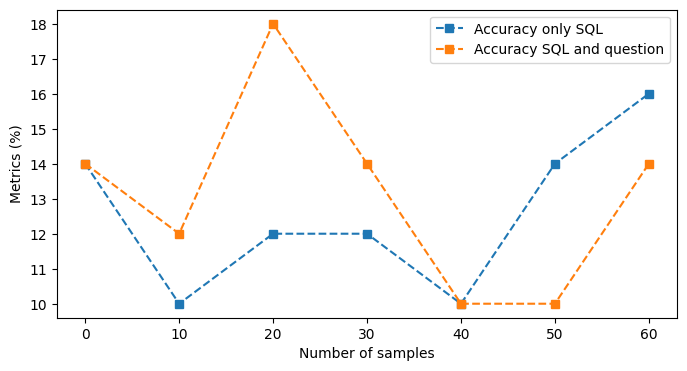

In [11]:
example_size  =[0, 10, 20, 30, 40,50, 60]
accuracy_only_sql = [14, 10, 12, 12, 10, 14, 16]
accuracy_q_a = [14, 12, 18, 14, 10, 10, 14]

fig, ax = plt.subplots(
    figsize=(8, 4)
)  # This sets the figure size to 6 inches wide by 5 inches high
# Plot the baseline

x= example_size
y=[accuracy_only_sql, accuracy_q_a]
labels = ['Accuracy only SQL', 'Accuracy SQL and question']
# Plot the three model lines
for i, label in enumerate(labels):
    ax.plot(x, y[i], linestyle='--', marker='s', label=label)

ax.set_xlabel("Number of samples")
ax.set_ylabel("Metrics (%)")
ax.legend()
plt.show()

### Rerunning tests
We now inspect the number of 20 exampls. Therefor we run the test multiple times and eventhough temperature is set to an minimum, top_p at 1 and the random_seed is fixed the results still differ too much.

That why we introduced an AVG-run where we use the majority answer of all 3 runs. And get most of the times 1 answer reoccuring in another run.


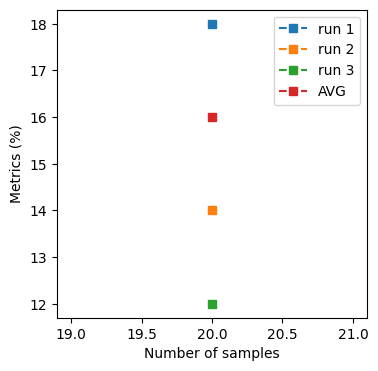

In [12]:
example_size  =[20]
accuracy_q_a_1 = [ 18]
accuracy_q_a_2 = [14]
accuracy_q_a_3 = [ 12]
accuracy_q_a_avg = [ 16]

fig, ax = plt.subplots(
    figsize=(4, 4)
)  # This sets the figure size to 6 inches wide by 5 inches high
# Plot the baseline

x= example_size
y=[accuracy_q_a_1, accuracy_q_a_2, accuracy_q_a_3, accuracy_q_a_avg]
labels = ['run 1', 'run 2', 'run 3', 'AVG']
# Plot the three model lines
for i, label in enumerate(labels):
    ax.plot(x, y[i], linestyle='--', marker='s', label=label)

ax.set_xlabel("Number of samples")
ax.set_ylabel("Metrics (%)")
ax.legend()#Memgpt
plt.show()

### Check the reoccurence of resulst
Here we inspected for each total number of samples, if we run the configuration with one total example number 3 times how often we get in those three runs for one question three different results.


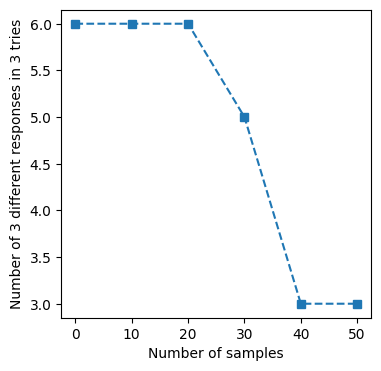

In [13]:
example_size  =[0,10,20,30,40,50]
distinct = [ 6, 6, 6, 5, 3, 3 ]

fig, ax = plt.subplots(
    figsize=(4, 4)
)  # This sets the figure size to 6 inches wide by 5 inches high
# Plot the baseline

x= example_size
y=[distinct]
# Plot the three model lines
ax.plot(x,distinct, linestyle='--', marker='s')

ax.set_xlabel("Number of samples")
ax.set_ylabel("Number of 3 different responses in 3 tries")
plt.show()

### Rerun Accuracy with Majority average
So now we wanted to check if we use the majority of an answer if we can extract ah perfect number of examples which still seems to be 20.


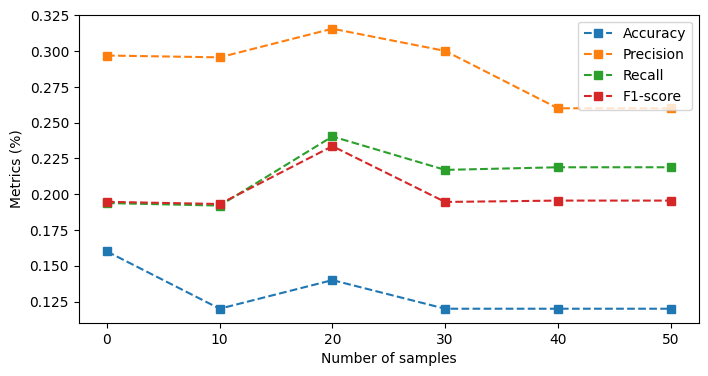

In [14]:
example_size  =[0, 10, 20, 30, 40,50]
accuracy_only_sql = [0.16, 0.12, 0.14, 0.12, 0.12, 0.12]
precision_only_sql = [0.2969417475728155, 0.2956660214014537, 0.31567014863354703, 0.3001670308667636, 0.26006777528363706, 0.26006777528363706]
recall_only_sql = [0.19384615384615386, 0.1920650883365159, 0.2403731396784062, 0.217013177136708, 0.21885391286082004, 0.21885391286082004]
f1_only_sql = [0.19470792020069286, 0.1931762750870442, 0.23360394578240598, 0.19461386463200966, 0.19556096792586444, 0.19556096792586444]
fig, ax = plt.subplots(
    figsize=(8, 4)
)  # This sets the figure size to 6 inches wide by 5 inches high
# Plot the baseline

x= example_size
y=[accuracy_only_sql, precision_only_sql, recall_only_sql, f1_only_sql]
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
# Plot the three model lines
for i, label in enumerate(labels):
    ax.plot(x, y[i], linestyle='--', marker='s', label=label)

ax.set_xlabel("Number of samples")
ax.set_ylabel("Metrics (%)")
ax.legend()
plt.show()

### Number of samples conversion to number of character
Since GPT is not restricted in the number of examples but in the number of chars we tried to check if there is a pattern between the sweet spot of the performance and the max number of characters of GPT-4.

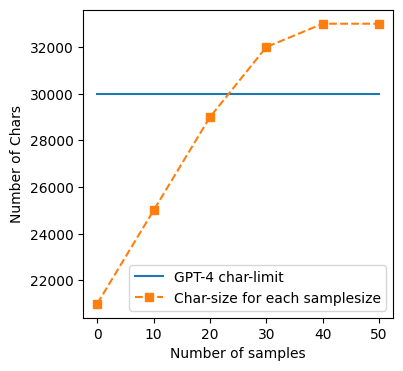

In [21]:
example_size  =[0,10,20,30,40,50]
distinct = [ 21000, 25000, 29000, 32000, 33000, 33000 ]

fig, ax = plt.subplots(
    figsize=(4, 4)
)  # This sets the figure size to 6 inches wide by 5 inches high
# Plot the baseline

x= example_size
y=[distinct]
# Plot the three model lines

ax.plot([x[0], x[-1]], [30000, 30000], label="GPT-4 char-limit")
ax.plot(x,distinct, linestyle='--', marker='s', label="Char-size for each samplesize")

ax.set_xlabel("Number of samples")
ax.set_ylabel("Number of Chars")
ax.legend()
plt.show()

In [23]:

df= pd.read_json(str(prefix) + '/data/metric-results.json')
df

,date,db_id,model,eval-type,num-of-table-retrieval,num-of-examples,accuracy,recall,precision,f1-score,num-of-runs,prim-and-freign-keys,dates
0,0,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.06,0.075881,0.343961,0.070023,5,Y,2024-06-11
1,0,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,5,1,0.04,0.027476,0.343227,0.023795,5,Y,2024-06-11
2,0,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,0,1,0.00,0.022080,0.473025,0.013663,5,Y,2024-06-11
3,0,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.06,0.075881,0.343961,0.070023,5,Y,2024-06-11
4,0,spider,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.48,0.533333,0.623333,0.509333,5,Y,2024-06-11
5,0,spider,gpt-3.5-turbo-0125,VALUE_EXTRACTION,5,1,0.30,0.300000,0.680000,0.300000,5,Y,2024-06-11
6,0,spider,gpt-3.5-turbo-0125,VALUE_EXTRACTION,0,1,0.12,0.120000,0.960000,0.120000,5,Y,2024-06-11
7,0,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,0,1,0.00,0.008894,0.511328,0.009034,5,Y,2024-06-12
8,0,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,5,1,0.04,0.044646,0.284121,0.044309,5,Y,2024-06-12
9,0,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,0,1,0.00,0.008894,0.511328,0.009034,5,Y,2024-06-12


In [39]:
dates= ["2024-06-11", "2024-06-11", "2024-06-11", "2024-06-11", "2024-06-11", "2024-06-11", "2024-06-11", "2024-06-12", "2024-06-12", "2024-06-12", "2024-06-13","2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13", "2024-06-13"]

In [44]:
if len(df) == len(dates):
    df['date'] = dates
else:
    print(len(dates))

In [43]:
df.drop('date', axis=1, inplace=True)

In [45]:

df

,db_id,model,eval-type,num-of-table-retrieval,num-of-examples,accuracy,recall,precision,f1-score,num-of-runs,prim-and-freign-keys,date
0,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.06,0.075881,0.343961,0.070023,5,Y,2024-06-11
1,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,5,1,0.04,0.027476,0.343227,0.023795,5,Y,2024-06-11
2,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,0,1,0.00,0.022080,0.473025,0.013663,5,Y,2024-06-11
3,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.06,0.075881,0.343961,0.070023,5,Y,2024-06-11
4,spider,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.48,0.533333,0.623333,0.509333,5,Y,2024-06-11
5,spider,gpt-3.5-turbo-0125,VALUE_EXTRACTION,5,1,0.30,0.300000,0.680000,0.300000,5,Y,2024-06-11
6,spider,gpt-3.5-turbo-0125,VALUE_EXTRACTION,0,1,0.12,0.120000,0.960000,0.120000,5,Y,2024-06-11
7,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,0,1,0.00,0.008894,0.511328,0.009034,5,Y,2024-06-12
8,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,5,1,0.04,0.044646,0.284121,0.044309,5,Y,2024-06-12
9,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,0,1,0.00,0.008894,0.511328,0.009034,5,Y,2024-06-12


In [46]:
df.to_json(str(prefix) + '/data/metric-results.json', orient='records')


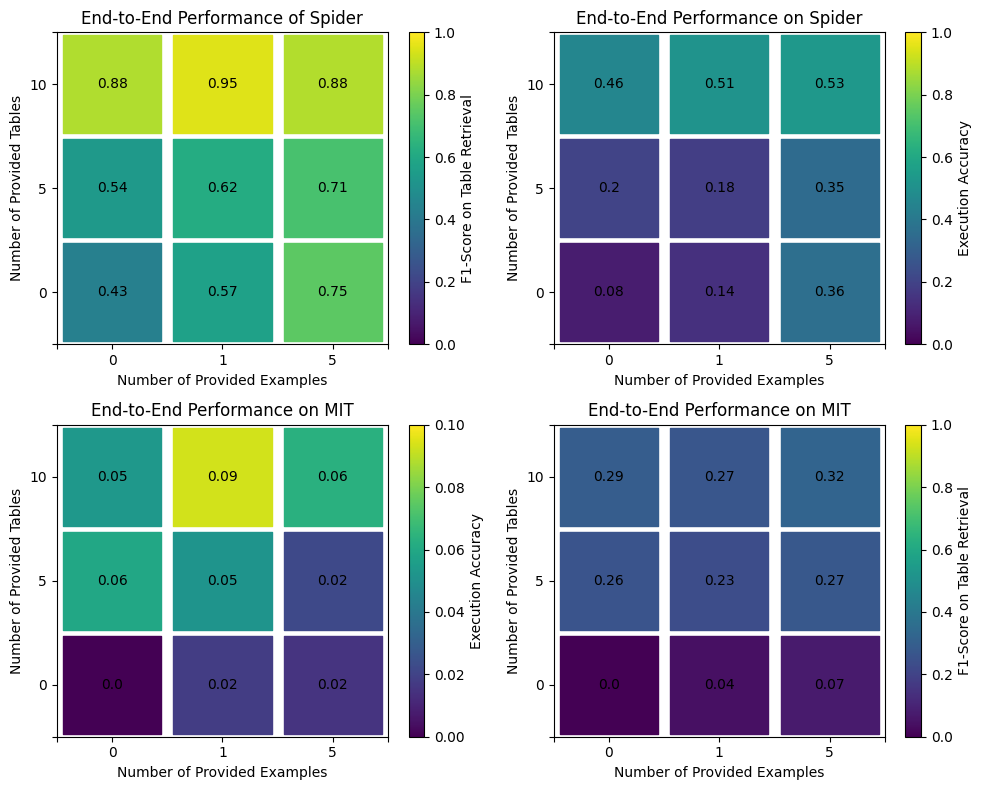

In [13]:

# Plot data on each subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Create a 2x2 grid of subplots

# Data for the first subplot
x1 = np.array([0, 1, 2])
y1 = np.array([0, 1, 2])
X1, Y1 = np.meshgrid(x1, y1)
z1 = np.array([0.43133333333333335, 0.5680000000000001, 0.7499999999999999, 0.5373333333333333, 0.6166666666666668, 0.7093333333333334, 0.8793333333333334, 0.9526666666666667, 0.8839999999999998])  # Random values for color (third dimension)

# Flatten X1 and Y1 to plot
x1_flat = X1.flatten()
y1_flat = Y1.flatten()

# Plot for the first subplot
scatter1 = axs[0, 0].scatter(x1_flat, y1_flat, c=z1, marker='s', cmap='viridis', s=5000, vmin=0, vmax=1)  # Use square markers with larger size
axs[0, 0].set_xticks([-0.5, 0, 1, 2, 2.5])
axs[0, 0].set_xticklabels(['', 0, 1, 5, ''])
axs[0, 0].set_yticks([-0.5, 0, 1, 2, 2.5])
axs[0, 0].set_yticklabels(['', 0, 5, 10, ''])
plt.colorbar(scatter1, ax=axs[0, 0], label='F1-Score on Table Retrieval')
axs[0, 0].set_xlabel('Number of Provided Examples')
axs[0, 0].set_ylabel('Number of Provided Tables')
axs[0, 0].set_title('End-to-End Performance of Spider')

# Add annotations
for i, txt in enumerate(z1):
    axs[0, 0].annotate(f'{round(txt, 2)}', (x1_flat[i], y1_flat[i]), textcoords="offset points", xytext=(0,0), ha='center', va='center')

# Data for the second subplot
x2 = np.array([0, 1, 2])
y2 = np.array([0, 1, 2])
X2, Y2 = np.meshgrid(x2, y2)
z2 = np.array([0.08, 0.14, 0.36, 0.2, 0.18, 0.3466666666666666, 0.46, 0.5133333333333333, 0.534])  # Random values for color (third dimension)

# Flatten X2 and Y2 to plot
x2_flat = X2.flatten()
y2_flat = Y2.flatten()

# Plot for the second subplot
scatter2 = axs[0, 1].scatter(x2_flat, y2_flat, c=z2, marker='s', cmap='viridis', s=5000, vmin=0, vmax=1)
axs[0, 1].set_xticks([-0.5, 0, 1, 2, 2.5])
axs[0, 1].set_xticklabels(['', 0, 1, 5, ''])
axs[0, 1].set_yticks([-0.5, 0, 1, 2, 2.5])
axs[0, 1].set_yticklabels(['', 0, 5, 10, ''])
plt.colorbar(scatter2, ax=axs[0, 1], label='Execution Accuracy')
axs[0, 1].set_xlabel('Number of Provided Examples')
axs[0, 1].set_ylabel('Number of Provided Tables')
axs[0, 1].set_title('End-to-End Performance on Spider')

# Add annotations
for i, txt in enumerate(z2):
    axs[0, 1].annotate(f'{round(txt, 2)}', (x2_flat[i], y2_flat[i]), textcoords="offset points", xytext=(0,0), ha='center', va='center')

# Data for the third subplot
x3 = np.array([0, 1, 2])
y3 = np.array([0, 1, 2])
X3, Y3 = np.meshgrid(x3, y3)
z3 = np.array([0.0, 0.01795, 0.01504, 0.0596346, 0.0517067, 0.022222222, 0.053129062142133886, 0.09308069454842167, 0.06339869281045753])

# Flatten X3 and Y3 to plot
x3_flat = X3.flatten()
y3_flat = Y3.flatten()

# Plot for the third subplot
scatter3 = axs[1, 0].scatter(x3_flat, y3_flat, c=z3, marker='s', cmap='viridis', s=5000, vmin=0, vmax=0.1)
axs[1, 0].set_xticks([-0.5, 0, 1, 2, 2.5])
axs[1, 0].set_xticklabels(['', 0, 1, 5, ''])
axs[1, 0].set_yticks([-0.5, 0, 1, 2, 2.5])
axs[1, 0].set_yticklabels(['', 0, 5, 10, ''])
plt.colorbar(scatter3, ax=axs[1, 0], label='Execution Accuracy')
axs[1, 0].set_xlabel('Number of Provided Examples')
axs[1, 0].set_ylabel('Number of Provided Tables')
axs[1, 0].set_title('End-to-End Performance on MIT')

# Add annotations
for i, txt in enumerate(z3):
    axs[1, 0].annotate(f'{round(txt, 2)}', (x3_flat[i], y3_flat[i]), textcoords="offset points", xytext=(0,0), ha='center', va='center')

# Data for the fourth subplot
x4 = np.array([0, 1, 2])
y4 = np.array([0, 1, 2])
X4, Y4 = np.meshgrid(x4, y4)
z4 = np.array([0.0, 0.04, 0.07333333333333333, 0.2580952380952381, 0.23209523809523808, 0.2713333333333333, 0.2894285714285714, 0.2695238095238095, 0.31642857142857145])

# Flatten X4 and Y4 to plot
x4_flat = X4.flatten()
y4_flat = Y4.flatten()

# Plot for the fourth subplot
scatter4 = axs[1, 1].scatter(x4_flat, y4_flat, c=z4, marker='s', cmap='viridis', s=5000, vmin=0, vmax=1)
axs[1, 1].set_xticks([-0.5, 0, 1, 2, 2.5])
axs[1, 1].set_xticklabels(['', 0, 1, 5, ''])
axs[1, 1].set_yticks([-0.5, 0, 1, 2, 2.5])
axs[1, 1].set_yticklabels(['', 0, 5, 10, ''])
plt.colorbar(scatter4, ax=axs[1, 1], label='F1-Score on Table Retrieval')
axs[1, 1].set_xlabel('Number of Provided Examples')
axs[1, 1].set_ylabel('Number of Provided Tables')
axs[1, 1].set_title('End-to-End Performance on MIT')

# Add annotations
for i, txt in enumerate(z4):
    axs[1, 1].annotate(f'{round(txt, 2)}', (x4_flat[i], y4_flat[i]), textcoords="offset points", xytext=(0,0), ha='center', va='center')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [68]:
df[df['db_id']=='mit']#[(df['eval-type']=='VALUE_EXTRACTION')==(df['prim-and-freign-keys']=='Y')]

,db_id,model,eval-type,num-of-table-retrieval,num-of-examples,accuracy,recall,precision,f1-score,num-of-runs,prim-and-freign-keys,date
0,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.06,0.075881,0.343961,0.070023,5,Y,2024-06-11
1,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,5,1,0.04,0.027476,0.343227,0.023795,5,Y,2024-06-11
2,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,0,1,0.00,0.022080,0.473025,0.013663,5,Y,2024-06-11
3,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.06,0.075881,0.343961,0.070023,5,Y,2024-06-11
7,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,0,1,0.00,0.008894,0.511328,0.009034,5,Y,2024-06-12
8,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,5,1,0.04,0.044646,0.284121,0.044309,5,Y,2024-06-12
9,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,0,1,0.00,0.008894,0.511328,0.009034,5,Y,2024-06-12
10,mit,gpt-3.5-turbo-16k,VALUE_EXTRACTION,10,1,0.04,0.063912,0.409264,0.065968,5,Y,2024-06-13
11,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,10,1,0.04,0.064765,0.404096,0.064403,5,N,2024-06-13
12,mit,gpt-3.5-turbo-0125,VALUE_EXTRACTION,5,1,0.06,0.104452,0.481043,0.098813,5,N,2024-06-13


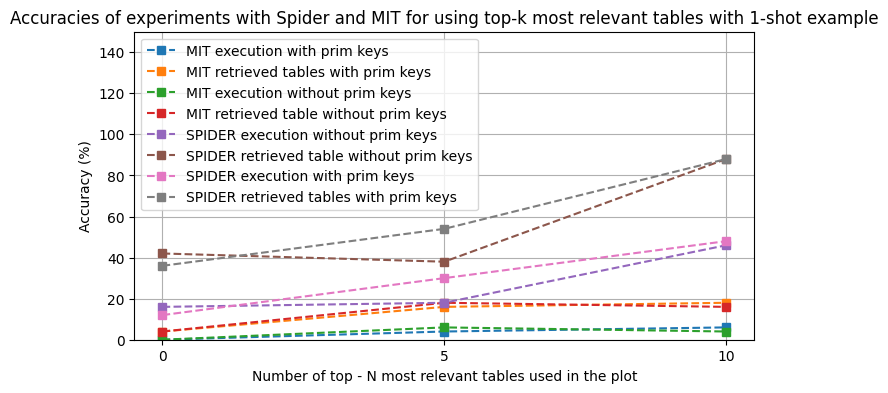

In [81]:
example_size  =[0, 5, 10]
accuracy_mit_exe_p = [0.0, 0.04, 0.06]
accuracy_mit_table_p = [0.04, 0.16, 0.18]
accuracy_mit_exe = [0.0, 0.06, 0.04]
accuracy_mit_table = [0.04, 0.18, 0.16]
accuracy_sp_exe = [0.16, 0.18, 0.46]
accuracy_sp_table = [0.42, 0.38, 0.88]
accuracy_sp_exe_p = [0.12, 0.30, 0.48]
accuracy_sp_table_p = [0.36, 0.54, 0.88]
fig, ax = plt.subplots(
    figsize=(8, 4)
)  # This sets the figure size to 6 inches wide by 5 inches high
# Plot the baseline

x= example_size
y=[accuracy_mit_exe_p,accuracy_mit_table_p,accuracy_mit_exe,accuracy_mit_table,accuracy_sp_exe,accuracy_sp_table,accuracy_sp_exe_p,accuracy_sp_table_p]
labels = ['MIT execution with prim keys', 'MIT retrieved tables with prim keys', 'MIT execution without prim keys','MIT retrieved table without prim keys',
          'SPIDER execution without prim keys','SPIDER retrieved table without prim keys','SPIDER execution with prim keys','SPIDER retrieved tables with prim keys']
# Plot the three model lines
for i, label in enumerate(labels):
    ax.plot(x, [y_ * 100 for y_ in y[i]], linestyle='--', marker='s', label=label)

ax.set_xlabel("Number of top - N most relevant tables used in the plot")
ax.set_ylabel("Accuracy (%)")
plt.xticks(example_size, ['0', '5', '10'])  # Set x-axis labels
plt.title('Accuracies of experiments with Spider and MIT for using top-k most relevant tables with 1-shot example')
plt.grid(True)
ax.set_ylim(0, 150)
ax.legend()
plt.show()